In [3]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [4]:
# 2. Đọc file dữ liệu chứng khoán BIDV và chia tập train test theo tỉ lệ 7:3
df = pd.read_csv('BIDV.csv')
df = df[['Close', 'High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA phù hợp nhất bằng auto_arima 
auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14523.786, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14525.723, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14525.730, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14521.897, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14527.729, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.008 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [6]:
model = VARMAX(train_data, order=(1, 1))
model_fit = model.fit(maxiter=1000, disp=False)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [14]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
close_pred = model_fit.forecast(steps=len(y_test))
y_pred = close_pred['Close'].to_numpy()

In [15]:
# 5. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Tạo một mảng gồm 90 số nguyên liên tiếp bắt đầu từ last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Dự đoán giá đóng cho 90 ngày tiếp theo
close_next_90_days = model_fit.forecast(steps=len(x_next_90_days))

y_next_90_days = close_next_90_days['Close'].to_numpy()

# In ra giá đóng đã được dự đoán trong 90 ngày tiếp theo
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[30196.90858036 30158.62275608 30140.44641332 30126.90298709
 30114.50460017 30102.46436867 30090.60393842 30078.88206497
 30067.28840528 30055.81958948 30044.47382986 30033.24970618
 30022.14589189 30011.16109235 30000.29403077 29989.54344496
 29978.90808643 29968.38672014 29957.97812429 29947.68109018
 29937.49442207 29927.41693703 29917.44746481 29907.58484771
 29897.82794041 29888.17560991 29878.62673533 29869.18020779
 29859.83493033 29850.58981771 29841.44379636 29832.39580418
 29823.44479047 29814.58971581 29805.82955188 29797.16328142
 29788.58989806 29780.10840621 29771.71782095 29763.41716793
 29755.20548323 29747.08181326 29739.04521468 29731.09475422
 29723.22950864 29715.44856458 29707.75101849 29700.13597647
 29692.60255424 29685.14987698 29677.77707923 29670.48330485
 29663.26770682 29656.12944725 29649.06769719 29642.08163661
 29635.17045425 29628.33334754 29621.56952252 29614.87819374
 29608.25858418 29601.70992513 29595.2

In [16]:
# 6. Tính độ đo RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 13533.874744322926


In [17]:
# 7. Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
print('Testing MAPE:', test_mape)

Testing MAPE: 28.18214323602905


In [18]:
# 8. Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - y_test))
print('Testing MAE:', test_mae)

Testing MAE: 12240.3463233201


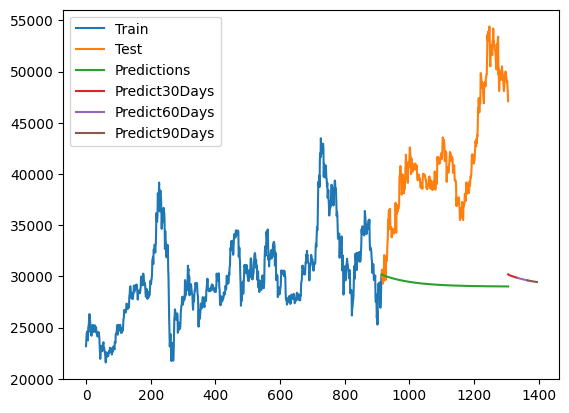

In [19]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Train', 'Test', 'Predictions','Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()

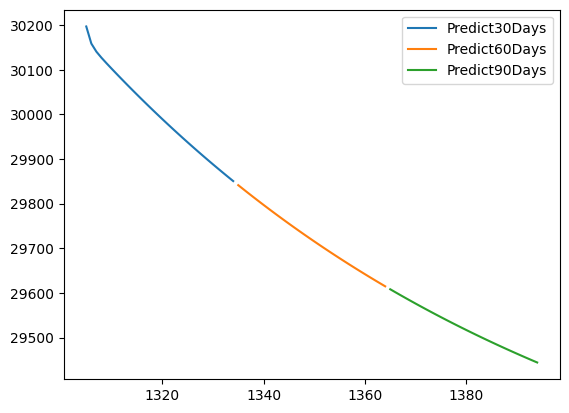

In [20]:
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()